# Run all train, all test and upload

In [1]:
import time
import numpy as np
from tools.csp import generate_projection, generate_eye, extract_feature
from tools.filters import load_filterbank
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tools.data import DreemDatasets
from preprocessing import Compose, ExtractBands, ExtractSpectrum
from models.riemannian_multiscale import riemannian_multiscale
import pandas as pd

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fs = 50.  # sampling frequency
NO_channels = 7  # number of EEG channels
NO_riem = int(NO_channels * NO_channels + 1) / 2  # Total number of CSP feature per band and timewindow
bw = np.array([2, 4, 8, 13, 22])
#bw = np.array([0.5, 4, 8, 13, 22])
ftype = 'butter'  # 'fir', 'butter'
forder = 2  # 4
filter_bank = load_filterbank(bw, fs, order=forder, max_freq=23, ftype=ftype)  # get filterbank coeffs
time_windows_flt = np.array([[0, 30],
                             [15, 30],
                             [10, 25],
                             [5, 20],
                             [0, 15],
                             [15, 25],
                             [10, 20],
                             [5, 15],
                             [0, 10]
]) * fs
"""
time_windows_flt = np.array([[0, 30],
                             [15, 30],
                             [10, 25],
                             [0, 30],
                             [0, 15],
                             [15, 25],
                             [10, 20],
                             [5, 15],
                             [0, 10]]) * fs

"""

time_windows = time_windows_flt.astype(int)
# restrict time windows and frequency bands
#time_windows = time_windows[0:1]  # use only largest timewindow
#time_windows = time_windows[2:3]
NO_bands = filter_bank.shape[0]
riem_opt = "Whitened_Euclid"  # {"Riemann","Riemann_Euclid","Whitened_Euclid","No_Adaptation"}
rho = 0.1
NO_csp = 24  # Total number of CSP feature per band and timewindow
useCSP = False

Todo : 

    1- Refaire le 62% sur tout le train (pas jsute le split)
    2- Add extra features EEG
    3- Add cross val
    3bis - On a 3 grosses méthodes (features normales + avec CSP + avec Rieman ) -> boosting
    4- Add 1 vs all
    5- Add destroy Features useless
    6- Try SVM
    7- Preprocess K-means 50 nuits

In [3]:
def get_data(path, train=True):
    if train:
        for i in range(7):
            if i==0:
                feature_0 = np.load("dataset/"+path+"/train_split/eeg_" + str(i + 1) + ".npy")
                X = np.zeros((7, feature_0.shape[0], feature_0.shape[1]))
                X[0] = feature_0
                del feature_0
            else:
                X[i] = np.load("dataset/"+path+"/train_split/eeg_" + str(i + 1) + ".npy")
        Y = np.load("dataset/"+path+"/train_split/targets.npy")
        X = X.transpose((1, 0, 2))
        return(X, Y)
    else:
        for i in range(7):
            if i==0:
                feature_0 = np.load("dataset/"+path+"/test/eeg_" + str(i + 1) + ".npy")
                X = np.zeros((7, feature_0.shape[0], feature_0.shape[1]))
                X[0] = feature_0
                del feature_0
            else:
                X[i] = np.load("dataset/"+path+"/test/eeg_" + str(i + 1) + ".npy")
        X = X.transpose((1, 0, 2))
        return(X)

def get_extra_data(path, train=True):
    if train:
        use_datasets = ["accelerometer_x","accelerometer_y","accelerometer_z","pulse_oximeter_infrared"]
        for i in range(4):
            if i==0:
                feature_0 = np.load("dataset/"+path+"/train_split/" + use_datasets[i] + ".npy").transpose((1, 0, 2))
                print(feature_0.shape)
                X = np.zeros((4, feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2]))
                X[i] = feature_0.reshape(feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2])
                del feature_0
            else:
                feature_0 = np.load("dataset/"+path+"/train_split/" + use_datasets[i] + ".npy").transpose((1, 0, 2))
                X[i] = feature_0.reshape(feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2])
                del feature_0
        Y = np.load("dataset/"+path+"/train_split/targets.npy")
        X = X.transpose((1, 0, 2))
        return(X, Y)
    else:
        use_datasets = ["accelerometer_x","accelerometer_y","accelerometer_z","pulse_oximeter_infrared"]
        for i in range(4):
            if i==0:
                feature_0 = np.load("dataset/"+path+"/test/" + use_datasets[i] + ".npy").transpose((1, 0, 2))
                print(feature_0.shape)
                X = np.zeros((4, feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2]))
                X[i] = feature_0.reshape(feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2])
                del feature_0
            else:
                feature_0 = np.load("dataset/"+path+"/test/" + use_datasets[i] + ".npy").transpose((1, 0, 2))
                X[i] = feature_0.reshape(feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2])
                del feature_0
        X = X.transpose((1, 0, 2))
        return(X)
    
def get_data_val(path):
    for i in range(7):
        if i==0:
            feature_0 = np.load("dataset/"+path+"/val_split/eeg_" + str(i + 1) + ".npy")
            X = np.zeros((7, feature_0.shape[0], feature_0.shape[1]))
            X[0] = feature_0
            del feature_0
        else:
            X[i] = np.load("dataset/"+path+"/val_split/eeg_" + str(i + 1) + ".npy")
    Y = np.load("dataset/"+path+"/val_split/targets.npy")
    X = X.transpose((1, 0, 2))
    return(X, Y)

def get_extra_data_val(path):
    use_datasets = ["accelerometer_x","accelerometer_y","accelerometer_z","pulse_oximeter_infrared"]
    for i in range(4):
        if i==0:
            feature_0 = np.load("dataset/"+path+"/val_split/" + use_datasets[i] + ".npy").transpose((1, 0, 2))
            print(feature_0.shape)
            X = np.zeros((4, feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2]))
            X[i] = feature_0.reshape(feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2])
            del feature_0
        else:
            feature_0 = np.load("dataset/"+path+"/val_split/" + use_datasets[i] + ".npy").transpose((1, 0, 2))
            X[i] = feature_0.reshape(feature_0.shape[0], feature_0.shape[1]*feature_0.shape[2])
            del feature_0
    Y = np.load("dataset/"+path+"/val_split/targets.npy")
    X = X.transpose((1, 0, 2))
    return(X, Y)

path = "all"
train_data, train_label = get_data(path, train = True)
path = "all"
test_data = get_data(path, train = False)
#eval_data, eval_label = get_data_val(path)


In [4]:
def get_features(data, label, time_windows, useCSP = True):
    if useCSP:
        w = generate_projection(data, label, NO_csp, filter_bank, time_windows, NO_classes=5)
    else:
        w = generate_eye(data, label, filter_bank, time_windows)
    feature_mat = extract_feature(data, w, filter_bank, time_windows)
    return(w, feature_mat)

In [5]:
w, train_feat_CSP = get_features(train_data, train_label, time_windows, useCSP)
#np.save("w_CSP_balanced_all.npy", w)
#np.save("features_train_CSP_balanced_all.npy", train_feat_CSP)
#del train_feat_CSP
test_feature_CSP = extract_feature(test_data, w, filter_bank, time_windows)
#np.save("features_test_CSP_balanced_all.npy", test_feature_CSP)
#del test_feature_CSP
#w=np.load("w_CSP_balanced_all.npy")
#eval_feature_CSP = extract_feature(eval_data, w, filter_bank, time_windows)
#np.save("features_val_CSP_balanced_all.npy", eval_feature_CSP)
#del eval_feature_CSP
del w

In [6]:
features_CSP_train = train_feat_CSP
#features_CSP_val = eval_feature_CSP
features_CSP_test = test_feature_CSP

In [8]:
riemann = riemannian_multiscale(filter_bank, time_windows, riem_opt=riem_opt, rho=rho, vectorized=True)
train_feat_R = riemann.fit(train_data)
#np.save("features_train_R_balanced_all.npy", train_feat_CSP)
#eval_feature_R = riemann.features(eval_data)
#np.save("features_val_R_balanced_all.npy", test_feature_CSP)
#test_feature_R = riemann.features(test_data)
#np.save("features_test_CSP_balanced_all.npy", eval_feature_CSP)

In [9]:
features_CSP_train = train_feat_R
features_CSP_val = eval_feature_R
#features_CSP_test = test_feature_R

## Get all features 

In [ ]:
"""
useCSP = False
start = time.time()
w, train_feat_CSP, test_feat_CSP = get_features(train_data, test_data, train_label, useCSP)
np.save("features_CSP_train_False.npy", train_feat_CSP)
np.save("features_CSP_test_False.npy", test_feat_CSP)
print(time.time()-start)
print("end CSP False")

del w
del train_feat_CSP
del test_feat_CSP

methods = ["No_Adaptation","Whitened_Euclid"]
for riem_opt in methods:
    try:
        start = time.time()
        riemann = riemannian_multiscale(filter_bank, time_windows, riem_opt=riem_opt, rho=rho, vectorized=True)
        train_feat_R = riemann.fit(train_data)
        test_feature_R = riemann.features(test_data)
        np.save("features_R_train_"+str(riem_opt), train_feat_CSP)
        np.save("features_R_test_"+str(riem_opt), test_feature_R)
        print(time.time()-start)
        print(riem_opt)
        del train_feat_R
        del test_feature_R
    except Exception as e:
        print(e)
        del train_feat_R
        del test_feature_R
        pass
"""

In [7]:
path = "all"
train_extra_data, train_extra_label = get_extra_data(path, train = True)
path = "all"
#val_extra_data, val_extra_label = get_extra_data_val(path)
test_extra_data = get_extra_data(path, train = False)
train_extra_data = train_extra_data.reshape(-1, 4*16)
#val_extra_data = val_extra_data.reshape(-1, 4*16)
test_extra_data = test_extra_data.reshape(-1,  4*16)

(30631, 4, 4)
(37439, 4, 4)


In [9]:
#_, train_label = get_data(path, train = True)
#features_CSP_train = np.load("features_train_CSP_balanced_all.npy")
#features_CSP_val = np.load("features_val_CSP_balanced_all.npy")
#features_CSP_test = np.load("features_test_CSP_balanced_all.npy")

all_final_features = features_CSP_train
all_final_features_test = features_CSP_test
#all_final_features_val = features_CSP_val

#all_final_features = np.concatenate((features_CSP_train, train_extra_data), axis= 1)
#all_final_features_test = np.concatenate((features_CSP_test, test_extra_data), axis= 1)
#all_final_features_val = np.concatenate((features_CSP_val, val_extra_data), axis= 1)
print(all_final_features.shape)
#print(all_final_features_test.shape)

(30631, 882)


In [12]:
train_label[train_label>2] = 0
train_label[train_label<2] = 0
train_label[train_label==2] = 1

eval_label[eval_label>2] = 0
eval_label[eval_label<2] = 0
eval_label[eval_label==2] = 1

In [8]:
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(all_final_features, train_label)
print("trained")


trained
predicted


In [9]:
labels_pred = clf.predict(all_final_features_val)
print("predicted")
CM = confusion_matrix(eval_label, labels_pred)
Acc = accuracy_score(eval_label, labels_pred)
F1 = f1_score(eval_label, labels_pred, average='macro')

print(CM, Acc, F1)

[[ 461   10  185    2   77]
 [  44   18  126    0   72]
 [  69   11 2891  110  356]
 [  15    0  491  669   11]
 [  55    5  621   14 1345]] 0.7030556281013319 0.5795945967947354


In [ ]:
labels_pred = clf.predict(all_final_features_test)
print("predicted")

df = pd.DataFrame(labels_pred)
df.to_csv('label_pred_all_R_white_sansextradata2.csv', header=["sleep_stage"])
print("done")

In [8]:
all_final_features = np.concatenate((features_CSP_train, train_extra_data), axis= 1)
all_final_features_test = np.concatenate((features_CSP_test, test_extra_data), axis= 1)
#all_final_features_val = np.concatenate((features_CSP_val, val_extra_data), axis= 1)
print(all_final_features.shape)
#print(all_final_features_test.shape)


clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(all_final_features, train_label)
print("trained")


(30631, 1198)
trained


In [ ]:
labels_pred = clf.predict(all_final_features_val)
print("predicted")

CM = confusion_matrix(eval_label, labels_pred)
Acc = accuracy_score(eval_label, labels_pred)
F1 = f1_score(eval_label, labels_pred, average='macro')

print(CM, Acc, F1)

In [9]:
labels_pred = clf.predict(all_final_features_test)
print("predicted")

predicted


In [10]:
df = pd.DataFrame(labels_pred)
df.to_csv('label_pred_pred_all_CSP_FAlse_white_avecextradata.csv', header=["sleep_stage"])
print("done")


done


NameError: name 'beeper' is not defined

Feature ranking:
1. feature 22 (0.003489)
2. feature 400 (0.003458)
3. feature 1134 (0.003276)
4. feature 1009 (0.003236)
5. feature 1150 (0.003169)
6. feature 526 (0.002972)
7. feature 148 (0.002917)
8. feature 71 (0.002856)
9. feature 50 (0.002803)
10. feature 29 (0.002737)
11. feature 1151 (0.002725)
12. feature 1167 (0.002632)
13. feature 274 (0.002630)
14. feature 904 (0.002593)
15. feature 1158 (0.002564)
16. feature 1135 (0.002511)
17. feature 652 (0.002493)
18. feature 57 (0.002485)
19. feature 197 (0.002461)
20. feature 575 (0.002422)
21. feature 449 (0.002378)
22. feature 1 (0.002318)
23. feature 1152 (0.002307)
24. feature 505 (0.002288)
25. feature 1189 (0.002283)
26. feature 1146 (0.002279)
27. feature 932 (0.002224)
28. feature 1166 (0.002214)
29. feature 778 (0.002202)
30. feature 1155 (0.002183)
31. feature 1147 (0.002159)
32. feature 127 (0.002156)
33. feature 631 (0.002146)
34. feature 428 (0.002109)
35. feature 435 (0.002078)
36. feature 1163 (0.002062)
37. feature 1

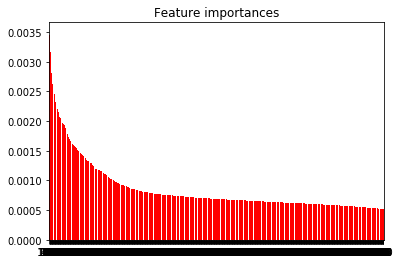

In [35]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features_CSP_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(1198), importances[indices],
       color="r", align="center")
plt.xticks(range(features_CSP_train.shape[1]), indices)
plt.xlim([-1, features_CSP_train.shape[1]])
plt.show()

In [13]:
train_label[train_label>2] = 0
train_label[train_label<2] = 0
train_label[train_label==2] = 1

eval_label[eval_label>2] = 0
eval_label[eval_label<2] = 0
eval_label[eval_label==2] = 1

In [14]:
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(all_final_features, train_label)
print("trained")
labels_pred = clf.predict(all_final_features_val)
print("predicted")

CM = confusion_matrix(eval_label, labels_pred)
Acc = accuracy_score(eval_label, labels_pred)
F1 = f1_score(eval_label, labels_pred, average='macro')

print(CM, Acc, F1)

trained
predicted
[[3534  687]
 [ 918 2519]] 0.7904152520240272 0.7866676094809699


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90784518d0>]],
      dtype=object)

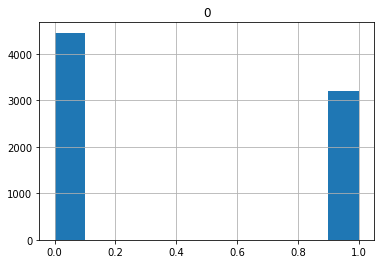

In [15]:
pd.DataFrame(labels_pred).hist()